# Sentinel-2 images analysis and preparation

### Installing and importing libraries

In [ ]:
# install required libraries
!pip install -q rasterio
!pip install geopandas

     |████████████████████████████████| 19.3 MB 1.5 MB/s 
     |████████████████████████████████| 994 kB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 45.3 MB/s 
     |████████████████████████████████| 15.4 MB 22 kB/s 


In [ ]:
from google.colab import files
import math
import rasterio
from rasterio.plot import show
import pandas as pd
import numpy as np
import geopandas
from shapely.geometry import Point
from osgeo import gdal, ogr, osr, gdalnumeric
import matplotlib.pyplot as plt

### Open image

In [ ]:
band2 = rasterio.open('T20HPD_20210715T140101_B02_10m.jp2', driver='JP2OpenJPEG') #blue
band3 = rasterio.open('T20HPD_20210715T140101_B03_10m.jp2', driver='JP2OpenJPEG') #green
band4 = rasterio.open('T20HPD_20210715T140101_B04_10m.jp2', driver='JP2OpenJPEG') #red
band8 = rasterio.open('T20HPD_20210715T140101_B08_10m.jp2', driver='JP2OpenJPEG') #nir

### Image analysis

In [ ]:
# Number of raster bands
band4.count

1

In [ ]:
# Number of raster columns
band4.width

10980

In [ ]:
# Number of raster rows
band4.height

10980

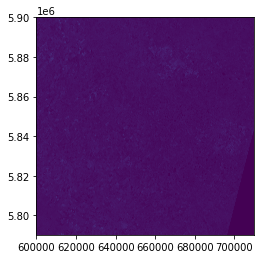

In [ ]:
# Plot band 
show(band4)

In [ ]:
# Type of raster byte
band4.dtypes[0]

'uint16'

In [ ]:
# Raster sytem of reference
band4.crs

CRS.from_epsg(32720)

In [ ]:
# Raster values as matrix array
band4.read(1)

array([[ 317,  126,  126, ...,  639,  641,  634],
       [ 660,  331,  112, ...,  736,  719,  673],
       [1015,  631,  329, ...,  722,  702,  633],
       ...,
       [ 987, 1030, 1018, ...,    0,    0,    0],
       [ 980, 1005, 1012, ...,    0,    0,    0],
       [ 972,  993,  970, ...,    0,    0,    0]], dtype=uint16)

### Raster plot and full raster download

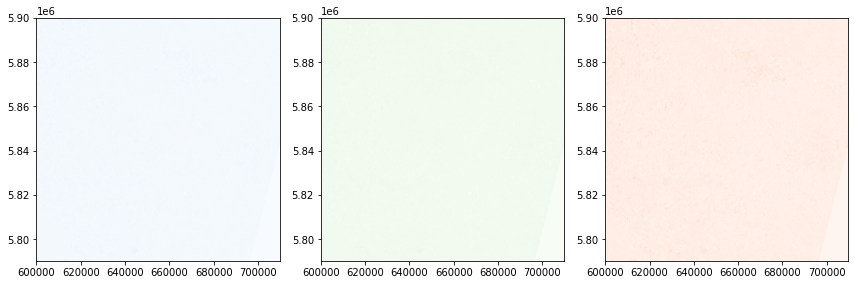

In [ ]:
# Multiple band representation
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
rasterio.plot.show(band2, ax=ax1, cmap = 'Blues')
rasterio.plot.show(band3, ax=ax2, cmap = 'Greens')
rasterio.plot.show(band4, ax=ax3, cmap = 'Reds')
fig.tight_layout()

In [ ]:
# Export true color image
trueColor = rasterio.open('SentinelTrueColor.tiff','w',driver='Gtiff',
                         width=band4.width, height=band4.height,
                         count=3,
                         crs=band4.crs,
                         transform=band4.transform,
                         dtype=band4.dtypes[0]
                         )
trueColor.write(band2.read(1),3) #blue
trueColor.write(band3.read(1),2) #green
trueColor.write(band4.read(1),1) #red
trueColor.close()

In [ ]:
files.download('SentinelTrueColor.tiff') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Dataframe to geodataframe and plotting to see the shape



In [ ]:
pringles_df = pd.read_excel('T28_Pringles.xls')

In [ ]:
pringles_df.head(4)

,NｰTransecta,Lote,DescLote,Lat1,Long1,DescPto1,Lat2,Long2,DescPto2,Lat3,Long3,DescPto3,Lat4,Long4,DescPto4,Lat5,Long5,DescPto5,Lat6,Long6,DescPto6,TipoCultivo,TipoLabranza,EstadoCultivo,CondCultivo,HumSuelo,MalezaT1,PresionMT1,MalezaT2,PresionMT2,MalezaT3,PresionMT3,MalezaT4,PresionMT4,MalezaT5,PresionMT5,MalezaT6,PresionMT6,MalezaOtros,PlagT1,...,PresionPT5,PlagT6,PresionPT6,PlagT7,PresionPT7,PlagT8,PresionPT8,PlagOtros,EnfT1,PresionET1,EnfT2,PresionET2,EnfT3,PresionET3,EnfT4,PresionET4,EnfT5,PresionET5,EnfT6,PresionET6,EnfOtros,AdvT1,PresionAT1,AdvT2,PresionAT2,AdvT3,PresionAT3,AdvT4,PresionAT4,AdvT5,PresionAT5,AdvT6,PresionAT6,AdvT7,PresionAT7,xxx,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87
0,28,T28_1,inicio transecta,-37.75737,-61.14537,inicio,-37.76056,-61.14937,fin,-37.75455,-61.15686,3 fin fondo. casa,0.00000,0.00000,0,0.0,0.0,0,0.0,0.0,0.0,3,0,Barbecho,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,28,T28_8,Don mario cn y verdeo,-37.78152,-61.15872,3 fin fondo,-37.77695,-61.15372,3 inicio fondo (molino),-37.77536,-61.16669,inicio,-37.77042,-61.16038,0,0.0,0.0,0,0.0,0.0,0.0,4,0,Verdeo invierno,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,28,T28_11,barbecho,-37.78248,-61.17755,inicio,-37.78851,-61.18501,fin,-37.78658,-61.18738,3 fin medio. inicio de la laguna,0.00000,0.00000,0,0.0,0.0,0,0.0,0.0,0.0,3,0,Barbecho,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,28,T28_10,cn con laguna,-37.78018,-61.17357,fin,-37.77544,-61.16673,inicio,-37.78291,-61.15729,3 inicio fondo,0.00000,0.00000,0,0.0,0.0,0,0.0,0.0,0.0,3,0,Campo natural,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
pringles_df_reprise = pringles_df[['EstadoCultivo','Long1', 'Lat1']]

In [ ]:
pringles_df_reprise.head()

,EstadoCultivo,Long1,Lat1
0,Barbecho,-61.14537,-37.75737
1,Verdeo invierno,-61.15872,-37.78152
2,Barbecho,-61.17755,-37.78248
3,Campo natural,-61.17357,-37.78018
4,Campo natural,-61.18501,-37.78850


In [ ]:
pringles_df_reprise['EstadoCultivo'].value_counts()

Pastura perenne    24
Campo natural      17
Barbecho           14
Verdeo invierno    10
Maﾃｭz               3
Trigo               2
Cebada              1
Name: EstadoCultivo, dtype: int64

Pandas dataframe into Geopandas dataframe

In [ ]:
pringles_gdf = geopandas.GeoDataFrame(
    pringles_df_reprise, geometry = geopandas.points_from_xy(pringles_df_reprise.Lat1, pringles_df_reprise.Long1),
    crs = 'epsg:32720')

In [ ]:
pringles_gdf.head()

,EstadoCultivo,Long1,Lat1,geometry
0,Barbecho,-61.14537,-37.75737,POINT (-37.75737 -61.14537)
1,Verdeo invierno,-61.15872,-37.78152,POINT (-37.78152 -61.15872)
2,Barbecho,-61.17755,-37.78248,POINT (-37.78248 -61.17755)
3,Campo natural,-61.17357,-37.78018,POINT (-37.78018 -61.17357)
4,Campo natural,-61.18501,-37.78850,POINT (-37.78850 -61.18501)


Plotting to see the shape

0     POINT (-37.75737 -61.14537)
1     POINT (-37.78152 -61.15872)
2     POINT (-37.78248 -61.17755)
3     POINT (-37.78018 -61.17357)
4     POINT (-37.78850 -61.18501)
                 ...             
66    POINT (-37.77156 -61.16342)
67    POINT (-37.93561 -61.28656)
68    POINT (-37.94165 -61.29232)
69    POINT (-37.77042 -61.16032)
70    POINT (-37.77145 -61.17118)
Name: geometry, Length: 71, dtype: geometry


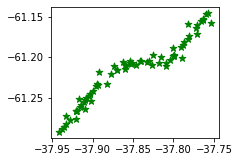

In [ ]:
print(pringles_gdf.geometry)
pringles_gdf.plot(marker='*', color='green', markersize=50, figsize=(3, 3));

### Plotting points over the raster

Dataframe with points

In [ ]:
df = pd.read_excel('T28_Pringles.xls')

Raster for a band

In [ ]:
raster = gdal.Open('T20HPD_20210715T140101_B02_10m.jp2', gdal.GA_ReadOnly)
array = raster.ReadAsArray()

Getting the interest points in the same coordinate than the image, and plotting them over the image

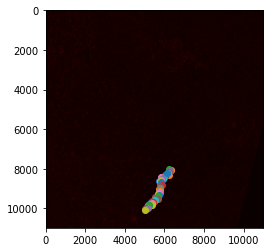

In [ ]:
# Transforming points

source = osr.SpatialReference() # Reference coordinate space (WGS84)
source.ImportFromEPSG(4326)  # WGS84 4326

crs = raster.GetProjection()
target = osr.SpatialReference() # Image coordinate space 
target.ImportFromWkt(crs)

transform = osr.CoordinateTransformation(source, target) # Transformation matrix

mx = np.zeros(df.Long1.size) # Converted coordinates
my = np.zeros(df.Long1.size)

# Coordinate converting to the map space
for i in range(df.Long1.size):
    lon, lat = df.Long1[i], df.Lat1[i]
    mx[i], my[i], z = transform.TransformPoint(lon, lat) 

    
gt = raster.GetGeoTransform()  # This allows the conversion from pixel to map coordinate
inv_gt = gdal.InvGeoTransform(gt)  # Inverting


# Original coordinates but converted to pixels in the image
px = np.zeros(df.Long1.size)
py = np.zeros(df.Long1.size)

# Geotransform applying and rounding to get the pixels coordinates
for i in range(df.Long1.size):
    px[i], py[i] = (math.floor(f) for f in gdal.ApplyGeoTransform(inv_gt, mx[i], my[i]))

plt.imshow(array, cmap = 'hot')
for i in range(df.Long1.size):
    plt.plot(px[i],py[i],'o')

### Cropping the raster in the interest points

In [ ]:
infile = "/content/SentinelTrueColor.tiff"
outfile = r'/content/output_{}.tiff'

# Your NxN window
N = 12

# Open the raster
with rasterio.open(infile) as dataset:

  source = osr.SpatialReference() # Reference coordinate space (WGS84)
  source.ImportFromEPSG(4326)  # WGS84 4326

  crs = dataset.crs.wkt
  target = osr.SpatialReference() # Image coordinate space 
  target.ImportFromWkt(crs)

  transform = osr.CoordinateTransformation(source, target) # Transformation matrix

  mx = np.zeros(df.Long1.size) # Converted coordinates
  my = np.zeros(df.Long1.size)

  # Coordinate converting to the map space
  for i in range(df.Long1.size):
      lon, lat = df.Long1[i], df.Lat1[i]
      mx[i], my[i], z = transform.TransformPoint(lon, lat) 

  coordinates = []
  for i in range(df.Long1.size):
    coordinates.append((mx[i],my[i]))

    # Loop through the list of coords
    for i, (lon, lat) in enumerate(coordinates):

        # Get pixel coordinates from map coordinates
        py, px = dataset.index(lon, lat)
        print('Pixel Y, X coords: {}, {}'.format(py, px))

        # Build an NxN window
        window = rasterio.windows.Window(px - N//2, py - N//2, N, N)
        print(window)

        # Read the data in the window
        # clip is a nbands * N * N numpy array
        clip = dataset.read(window=window)

        # You can then write out a new file
        meta = dataset.meta
        meta['width'], meta['height'] = N, N
        meta['transform'] = rasterio.windows.transform(window, dataset.transform)

        with rasterio.open(outfile.format(i), 'w', **meta) as dst:
            dst.write(clip)

Se han truncado las últimas 5000 líneas del flujo de salida.
Pixel Y, X coords: 8319, 6214
Window(col_off=6208, row_off=8313, width=12, height=12)
Pixel Y, X coords: 8326, 6048
Window(col_off=6042, row_off=8320, width=12, height=12)
Pixel Y, X coords: 8301, 6084
Window(col_off=6078, row_off=8295, width=12, height=12)
Pixel Y, X coords: 8392, 5981
Window(col_off=5975, row_off=8386, width=12, height=12)
Pixel Y, X coords: 8370, 6018
Window(col_off=6012, row_off=8364, width=12, height=12)
Pixel Y, X coords: 8405, 5837
Window(col_off=5831, row_off=8399, width=12, height=12)
Pixel Y, X coords: 8416, 5959
Window(col_off=5953, row_off=8410, width=12, height=12)
Pixel Y, X coords: 8513, 5860
Window(col_off=5854, row_off=8507, width=12, height=12)
Pixel Y, X coords: 8521, 5947
Window(col_off=5941, row_off=8515, width=12, height=12)
Pixel Y, X coords: 8616, 5746
Window(col_off=5740, row_off=8610, width=12, height=12)
Pixel Y, X coords: 8053, 6337
Window(col_off=6331, row_off=8047, width=12, heig

# CNN classification

### Importing libraries

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

### Opening images and creating labels

Opening images and converting them to uint8

In [ ]:
infile = r'/content/output_{}.tiff'
images = []
nunber_of_images = 71

for i in range(nunber_of_images):
  with rasterio.open(infile.format(i)) as src:
      arr = src.read()
      images.append(arr.astype('uint8'))

In [ ]:
X = np.array(images, dtype=np.uint8) # List to numpy array

Creating labels

In [ ]:
def retrieve_label(estado_cultivo):
  if estado_cultivo == 'Pastura perenne' or estado_cultivo == 'Verdeo invierno':
    return 0
  else:
    return 1

In [ ]:
pringles_df = pd.read_excel('T28_Pringles.xls')

In [ ]:
pringles_df['EstadoCultivo'].value_counts()

Pastura perenne    24
Campo natural      17
Barbecho           14
Verdeo invierno    10
Maﾃｭz               3
Trigo               2
Cebada              1
Name: EstadoCultivo, dtype: int64

Converting labels list to numpy array and counting the number of classes

In [ ]:
pringles_df['labels'] = pringles_df['EstadoCultivo'].apply(retrieve_label)
y = pringles_df['labels'].to_numpy(dtype = 'uint8')

In [ ]:
classes = np.unique(y)
number_of_classes = len(classes)

### Data preparation

In [ ]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size = 0.3)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)
 
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.
 
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = keras.utils.to_categorical(train_Y)
test_Y_one_hot = keras.utils.to_categorical(test_Y)
 
# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])
 
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)
 
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

Training data shape :  (49, 3, 12, 12) (49,)
Testing data shape :  (22, 3, 12, 12) (22,)
Original label: 1
After conversion to one-hot: [0. 1.]
(39, 3, 12, 12) (10, 3, 12, 12) (39, 2) (10, 2)


### CNN architecture

In [ ]:
INIT_LR = 1e-3
epochs = 10
batch_size = 12
 
harvest_model = Sequential()
harvest_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(3,12,12)))
harvest_model.add(LeakyReLU(alpha=0.1))
harvest_model.add(MaxPooling2D((2, 2),padding='same'))
harvest_model.add(Dropout(0.5))
 
harvest_model.add(Flatten())
harvest_model.add(Dense(32, activation='linear'))
harvest_model.add(LeakyReLU(alpha=0.1))
harvest_model.add(Dropout(0.5)) 
harvest_model.add(Dense(number_of_classes, activation='softmax'))
 
harvest_model.summary()
 
harvest_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 3, 12, 32)         3488      
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 3, 12, 32)         0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 2, 6, 32)          0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 2, 6, 32)          0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 384)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 32)                12320     
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 32)              

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### CNN training

In [ ]:
history = harvest_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))


Epoch 1/10
4/4 [==============================] - 1s 137ms/step - loss: 0.9906 - accuracy: 0.4959 - val_loss: 0.7485 - val_accuracy: 0.6000
Epoch 2/10
4/4 [==============================] - 0s 10ms/step - loss: 0.7028 - accuracy: 0.6201 - val_loss: 0.7155 - val_accuracy: 0.6000
Epoch 3/10
4/4 [==============================] - 0s 9ms/step - loss: 1.0818 - accuracy: 0.2387 - val_loss: 0.6957 - val_accuracy: 0.6000
Epoch 4/10
4/4 [==============================] - 0s 10ms/step - loss: 0.8804 - accuracy: 0.5515 - val_loss: 0.6870 - val_accuracy: 0.6000
Epoch 5/10
4/4 [==============================] - 0s 10ms/step - loss: 0.7665 - accuracy: 0.6276 - val_loss: 0.6913 - val_accuracy: 0.6000
Epoch 6/10
4/4 [==============================] - 0s 9ms/step - loss: 0.7866 - accuracy: 0.4385 - val_loss: 0.6968 - val_accuracy: 0.5000
Epoch 7/10
4/4 [==============================] - 0s 9ms/step - loss: 0.7818 - accuracy: 0.6833 - val_loss: 0.7046 - val_accuracy: 0.5000
Epoch 8/10
4/4 [=============

### CNN performance

1/1 [==============================] - 0s 17ms/step - loss: 0.6546 - accuracy: 0.6818


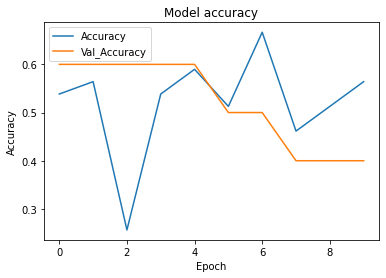

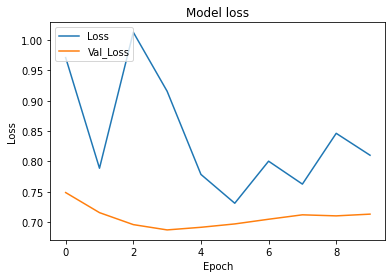

In [ ]:
results = harvest_model.evaluate(test_X, test_Y_one_hot, verbose=1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val_Accuracy'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val_Loss'], loc='upper left')
plt.show()

### Classification report

In [ ]:
y_predicted = harvest_model.predict(test_X)

In [ ]:
for element in y_predicted:
  if element[0] > element[1]:
    element[0] = 1
    element[1] = 0
  else:
    element[0] = 0
    element[1] = 1

In [ ]:
print("Classification report for classifier \n{}\n".format(classification_report(test_Y_one_hot, y_predicted)))

Classification report for classifier 
              precision    recall  f1-score   support

           0       0.59      1.00      0.74        10
           1       1.00      0.42      0.59        12

   micro avg       0.68      0.68      0.68        22
   macro avg       0.79      0.71      0.66        22
weighted avg       0.81      0.68      0.66        22
 samples avg       0.68      0.68      0.68        22


